# Example of PCA scree plot and how to determine the number of relevant principal components to keep.

Principal Component Analysis is a very popular method to reduce the dimensionality of data. This is particularly useful 
when we want to classify data in large dimensions. It can also be used as a visualisation tool to project data in 
a lower dimension space (data embedding).  

## The PCA transform
This linear transform allows us to move from the natural/original space $\cal{X}$ into the component space $\cal{Z}$ and is defined as 
<blockquote>  $\bf{z} = \bf{W}^{T}(\bf{x}-\bf{\mu})$</blockquote>

with 
<blockquote> 
$\begin{align}
\bf{x} &= [x_{1} x_{2} \cdots  x_{N}]^\top \\
\bf{\mu} &= [\mu_{1} \mu_{2} \cdots \mu_{N}]^\top  \\
\bf{z} &= [z_{1} z_{2} \cdots z_{N}]^\top  \\
\end{align}$
</blockquote>

where N is the dimension of space and $\bf{\mu}$ is the mean of the N-dimensional data X. 

The $W$ matrix if made of the N eigenvectors $\bf{w}_{i}$ of the covariance matrix $\Sigma$. They are stacked together along columns

<blockquote>  
$\begin{align}
\bf{W} &= \begin{pmatrix} \bf{w}_{1} & \bf{w}_{2} & \dotsb & \bf{w}_{N}  \end{pmatrix} \\
&= \begin{pmatrix} w_{1,1} & w_{2,1} & \dotsb & w_{N,1} \\
w_{1,2} & w_{2,2} & \dotsb & w_{N,2} \\
\vdots &  \vdots & \dotsb & \vdots \\
w_{1,N} & w_{2,N} & \dotsb & w_{N,N} \end{pmatrix} 
\end{align}$                
</blockquote>

As for the covariance matrix $\Sigma$, it is computed from the N-dimensional data distribution X 

<blockquote>  
$
\begin{align}
\bf{\Sigma} &= E\{(\bf{x}-\bf{\mu})(\bf{x}-\bf{\mu})^{T} \} \\
&= \begin{pmatrix} \sigma_{1}^2 & \sigma_{1,2} & \cdots & \sigma_{1,N} \\ 
\sigma_{1,2} & \sigma_{2}^2 & \cdots & \sigma_{2,N} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{1,N} & \sigma_{2,N} & \cdots & \sigma_{N}^2 \end{pmatrix}
\end{align}
$                
</blockquote>

The $\it{inverse}$ PCA transform allows us to move from the component space $\cal{Z}$ back to the natural/original space $\cal{X}$ 
and is defined as 

<blockquote>  $\bf{x} = \bf{W}\bf{z} + \bf{\mu}$</blockquote>

The principal components $\bf{z}$ are sorted in decreasing order of variance $var(z_{i})=\lambda_{i}$ where the $\lambda_{i}$ are 
the eigenvalues of the covariance matrix $\bf{\Sigma}$. The scree plot associated to PCA displays $\lambda$ $\it{versus}$ 
the component number as we will see below.

N.B. The principal components usually come in one of the two popular notations: $z_{i}$ or $PCA_{i}$.


## PCA as a tool for dimensionality reduction

The last equation shows that we can reconstruct exactly the vector $\bf{x}$. We usually drop the 
least significant principal components (the last components in z and the last columns of $\bf{W}$) 
as they contain the least information and are often corrupted with noise. This produces 
an approximate reconstruction of $\bf{x}$ 

<blockquote>  $\bf{x} \approx \bf{\tilde{W}}\bf{\tilde{z}} + \bf{\mu}$</blockquote>

with the modified arrays

<blockquote>  $\bf{\tilde{z}} = \begin{pmatrix} z_{1} \ z_{2} \ \dotsb \ z_{M} \end{pmatrix}^{T} $ </blockquote>

and

<blockquote>  
$
\begin{align}
\bf{\tilde{W}} &= \begin{pmatrix} \bf{w}_{1} & \bf{w}_{2} & \dotsb & \bf{w}_{M}  \end{pmatrix} \\
&= \begin{pmatrix} w_{1,1} & w_{2,1} & \dotsb & w_{M,1} \\
w_{1,2} & w_{2,2} & \dotsb & w_{M,2} \\
\vdots &  \vdots & \ddots & \vdots \\
w_{1,N} & w_{2,N} & \dotsb & w_{M,N} \end{pmatrix} 
\end{align}
$                
</blockquote>


We will show in this script how the scree plot can be used as a tool for finding out the optimal number of 
components (M<N) to keep. Our approach is based on the reconstruction errors introduced 
when dimensionality reduction is applied to the original data X. 


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces

import random
from numpy.random import RandomState
import seaborn as sns
sns.set(color_codes=True)

# Used for reproductibility of the results
np.random.seed(43)

Automatically created module for IPython interactive environment


# Data preprocessing

### Load the Olivetti faces dataset. 

The dataset contains 400 images of size 64 x 64 that are each stored into a column of 4096 elements. The original 400 x 4096 data 
must be reshaped into 4096 x 400 data. Hence, each line will correspond to an image (an observation) and each 
column will correspond to a feature. 

In [2]:
X, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=RandomState(0))

# Reshape the array 
X = X.T


Let us show a few (unsmoothed) images in the dataset. They contain visible quantisation noise and 
probably also gaussian noise from electronics and Poisson noise from photon statistics. The PCA analysis 
will reveal the impact of noise in the images. 

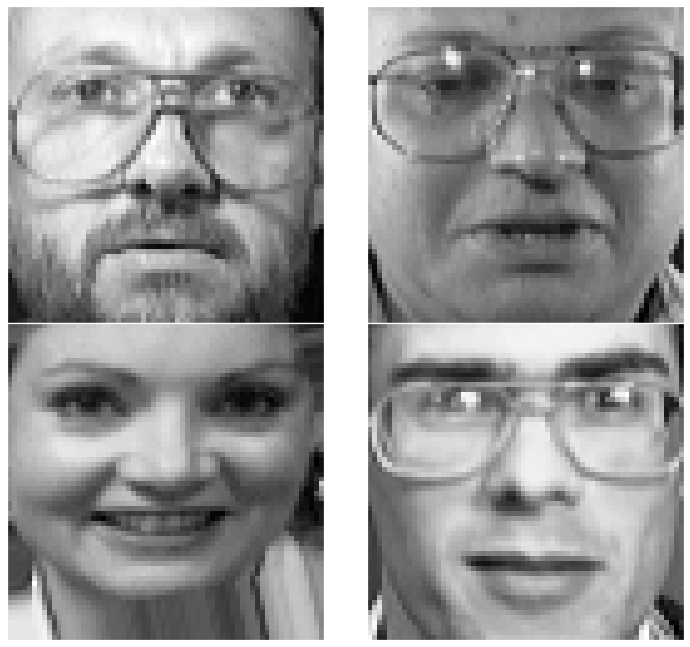

In [3]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
for i in range(4):
    plt.subplot(2,2, i + 1)
    plt.imshow(X[:,i].reshape(64, 64), cmap='gray', interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

plt.savefig('13.2.1_Examples_from_Olivetti_face_dataset.png')
plt.savefig('13.2.1_Examples_from_Olivetti_face_dataset.pdf')

### Split the dataset into a training and a test datasets

In [4]:
X_train, X_test = train_test_split(X, random_state=0,train_size=0.8)


### Normalise the data
The normalisation transform is defined with the training dataset. Both training and test datasets are then normalised with it. 

In [5]:
sc = StandardScaler().fit(X_train)

X_train_s = sc.transform(X_train)
X_test_s = sc.transform(X_test)

## PCA approximation and data reconstruction

In this section, we apply the PCA transform to the training dataset and then reconstruct it using only a 
fraction of the principal components. The result is an approximation of the training dataset.

Next, we apply the same PCA transform, i.e. defined for the training dataset, to the test dataset and reconstruct it using 
the same procedure as before. The result is also an approximation of the test dataset, but it is based on the 
training principal components, not on the test principal components (which are not computed here).

Warning: the next cell takes a few seconds to a minute to compute. In a few years from now, this warning will be pointless 
given the increasing speeds of hardware and software!

In [6]:
(n_images,n_components) = X_train.shape

error_train = np.zeros((n_components,1))
error_test = np.zeros((n_components,1))

for i in range(1,n_components+1):
    # Compute the PCA transform using only the first i principal components of the training dataset 
    pca = PCA(n_components=i)
    pca.fit(X_train_s)

    # Apply the PCA transform to the training dataset and extract the first i principal components 
    Z = pca.transform(X_train_s)    
    
    # Reconstruct the training dataset using this reduced set of principal components
    x_train = pca.inverse_transform(Z)
    
    # Remove the normalisation transform
    x_train = sc.inverse_transform(x_train)
        
    # Apply the same PCA transform to the test dataset and extract the first i principal components 
    Z = pca.transform(X_test_s)
    
    # Reconstruct the test dataset using the reduced set of principal components    
    x_test = pca.inverse_transform(Z)
    
    # Remove the normalisation transform    
    x_test = sc.inverse_transform(x_test)

    # Compute the reconstruction error for each dataset
    error_train[i-1] = np.square(np.subtract(x_train, X_train)).mean()
    error_test[i-1] = np.square(np.subtract(x_test, X_test)).mean()


## Display the PCA scree plot and the reconstruction errors

The scree plot shows the eigenvalues in a decreasing order. The most relevant eigenvectors are on the left and 
the least relevant ones on the right. The sharp bend is often called the 'knee' of the curve.

The second panel shows the reconstruction errors for both training and test datasets. There are slight differences 
between the two overlapping curves.

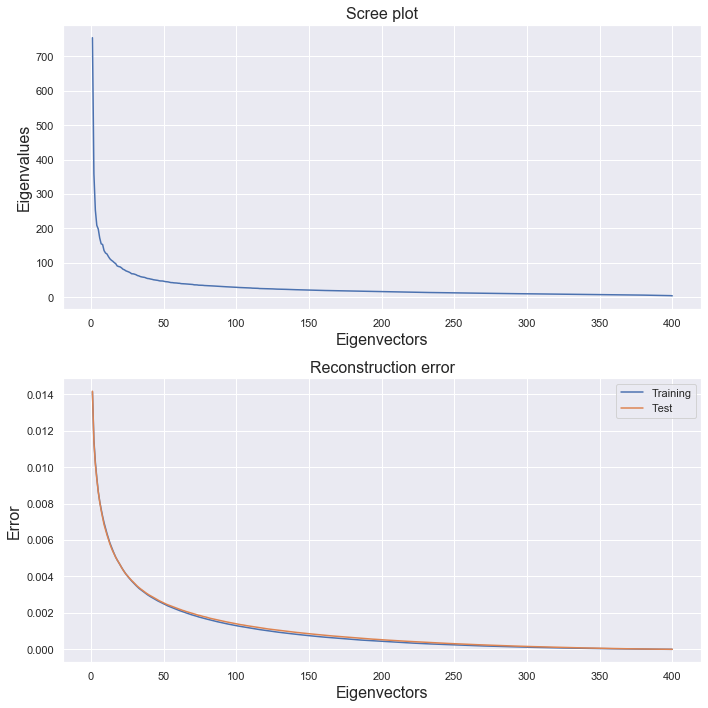

In [7]:
n_comp = np.arange(1,n_components+1)

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(n_comp, pca.singular_values_) 
ax[0].set_xlabel('Eigenvectors', fontsize=16)
ax[0].set_ylabel('Eigenvalues', fontsize=16)
ax[0].set_title('Scree plot', fontsize=16)


ax[1].plot(n_comp, error_train, label='Training') 
ax[1].plot(n_comp, error_test, label='Test') 
ax[1].set_xlabel('Eigenvectors', fontsize=16)
ax[1].set_ylabel('Error', fontsize=16)
ax[1].set_title('Reconstruction error', fontsize=16)
ax[1].legend()

fig.tight_layout()  

plt.savefig('13.2.2_Scree_plot_and_reconstruction_errors.png')
plt.savefig('13.2.2_Scree_plot_and_reconstruction_errors.pdf')

Let us zoom on the first 100 components in the second panel and reframe it to make differences in reconstruction errors 
more visible. After roughly 25 eigenvectors, the reconstruction errors for the test dataset become larger than those 
for the training one; both error curves start diverging.

Hence, the next eigenvectors describe features in the training data that become less relevant to 
the test data. Because the test errors continue to decrease nevertheless, those features do not contain noise only, otherwise 
the reconstruction error would flatten out. 

The next components become more affected by noise. If there were no noise, both reconstruction errors 
would be similar and continue to decrease at the same rate because statistically speaking, the two datasets are 
well balanced and should contain similar principal components. Up to a certain point of course; they are 
similar but not identical. 

The difference in reconstruction errors indicates that the noise becomes more important in the next eigenvectors. 
If a choice had to be made between the eigenvectors to keep and those to drop, it would be there. The signal-to-noise 
ratio for the principal components starts to decrease past that point. 


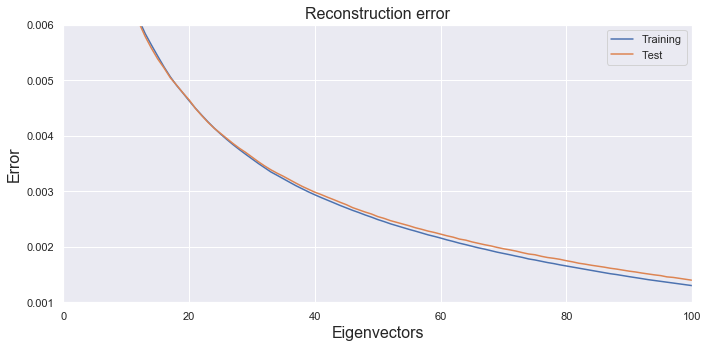

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, error_train, label='Training') 
ax.plot(n_comp, error_test, label='Test') 
ax.set_xlabel('Eigenvectors', fontsize=16)
ax.set_ylabel('Error', fontsize=16)
ax.set_title('Reconstruction error', fontsize=16)
ax.legend()
ax.set_ylim([0.001, 0.006])
ax.set_xlim([0, 100])

fig.tight_layout()  

plt.savefig('13.2.3_Zoom_on_reconstruction_errors.png')
plt.savefig('13.2.3_Zoom_on_reconstruction_errors.pdf')

In the next figure, the star indicates where the noise starts to seriously affect the true information, i.e. at eigenvector #25. 
The star coincides with the 'knee' of the scree plot! 

This approach, based on reconstruction errors, works best when there is a 'knee' in the scree plot. With some datasets, 
the scree plot shows a monotonously decreasing curve. The reconstruction error explanation is less convincing in these cases.  

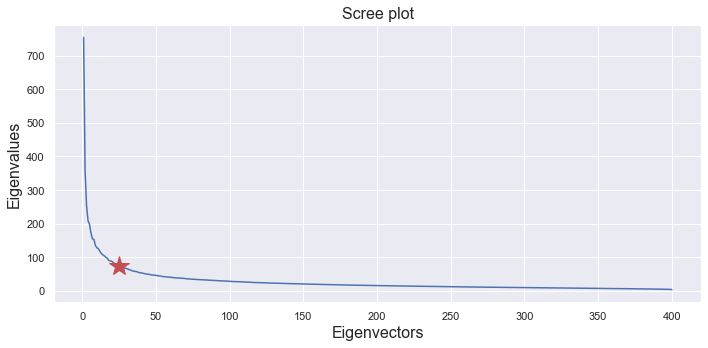

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(n_comp, pca.singular_values_) 
ax.set_xlabel('Eigenvectors', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
ax.set_title('Scree plot', fontsize=16)
ax.plot(25., 75, '*', color='r', markersize=20)

fig.tight_layout()  

plt.savefig('13.2.4_Optimal_number_of_components_to_keep.png')
plt.savefig('13.2.4_Optimal_number_of_components_to_keep.pdf')